# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [161]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [162]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv",sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv",sep=";") # it was necessary use ;

In [163]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head(n=7)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0


In [164]:
feat_info.head(n=7)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [165]:
# Identify missing or unknown data values and convert them to NaNs.


azdias.AGER_TYP.isnull().sum()

#practice
#remember split 

print(feat_info.loc[1,'missing_or_unknown'])
print(str(feat_info.loc[1,'missing_or_unknown']).strip('[]').split(',')) 
print(len(str(feat_info.loc[1,'missing_or_unknown']).strip('[]').split(',')))

list_cret = str(feat_info.loc[1,'missing_or_unknown']).strip('[]').split(',')
print(list_cret[0])
print(list_cret[1])




[-1,0,9]
['-1', '0', '9']
3
-1
0


In [166]:
azdias.head(n=4) #before 

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0


In [167]:
# Identify missing or unknown data values and convert them to NaNs.
for n_col in feat_info.index:
    feat_info.loc[n_col,'missing_or_unknown'] = str(feat_info.loc[n_col,'missing_or_unknown']).strip('[]').split(',')
    for idx in range(0,len(feat_info.loc[n_col,'missing_or_unknown'])):
        try:
            feat_info.loc[n_col,'missing_or_unknown'][idx] = int(feat_info.loc[n_col,'missing_or_unknown'][idx])
        except:
            continue
    azdias.loc[:,(feat_info.loc[n_col, 'attribute'])].replace(feat_info.loc[n_col,'missing_or_unknown'], np.nan, inplace=True)

In [168]:
a=[1,2,3]
range(0,len(a))

range(0, 3)

In [169]:
#check
print(azdias["CAMEO_INTL_2015"].str[0].astype("float").value_counts())
feat_info.loc[59,'missing_or_unknown'][1]
feat_info.loc[59,:]

5.0    223582
2.0    190691
4.0    189960
1.0    119443
3.0     68193
Name: CAMEO_INTL_2015, dtype: int64


attribute             CAMEO_INTL_2015
information_level       microcell_rr4
type                            mixed
missing_or_unknown           [-1, XX]
Name: 59, dtype: object

In [170]:
azdias.head(n=4) #after

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

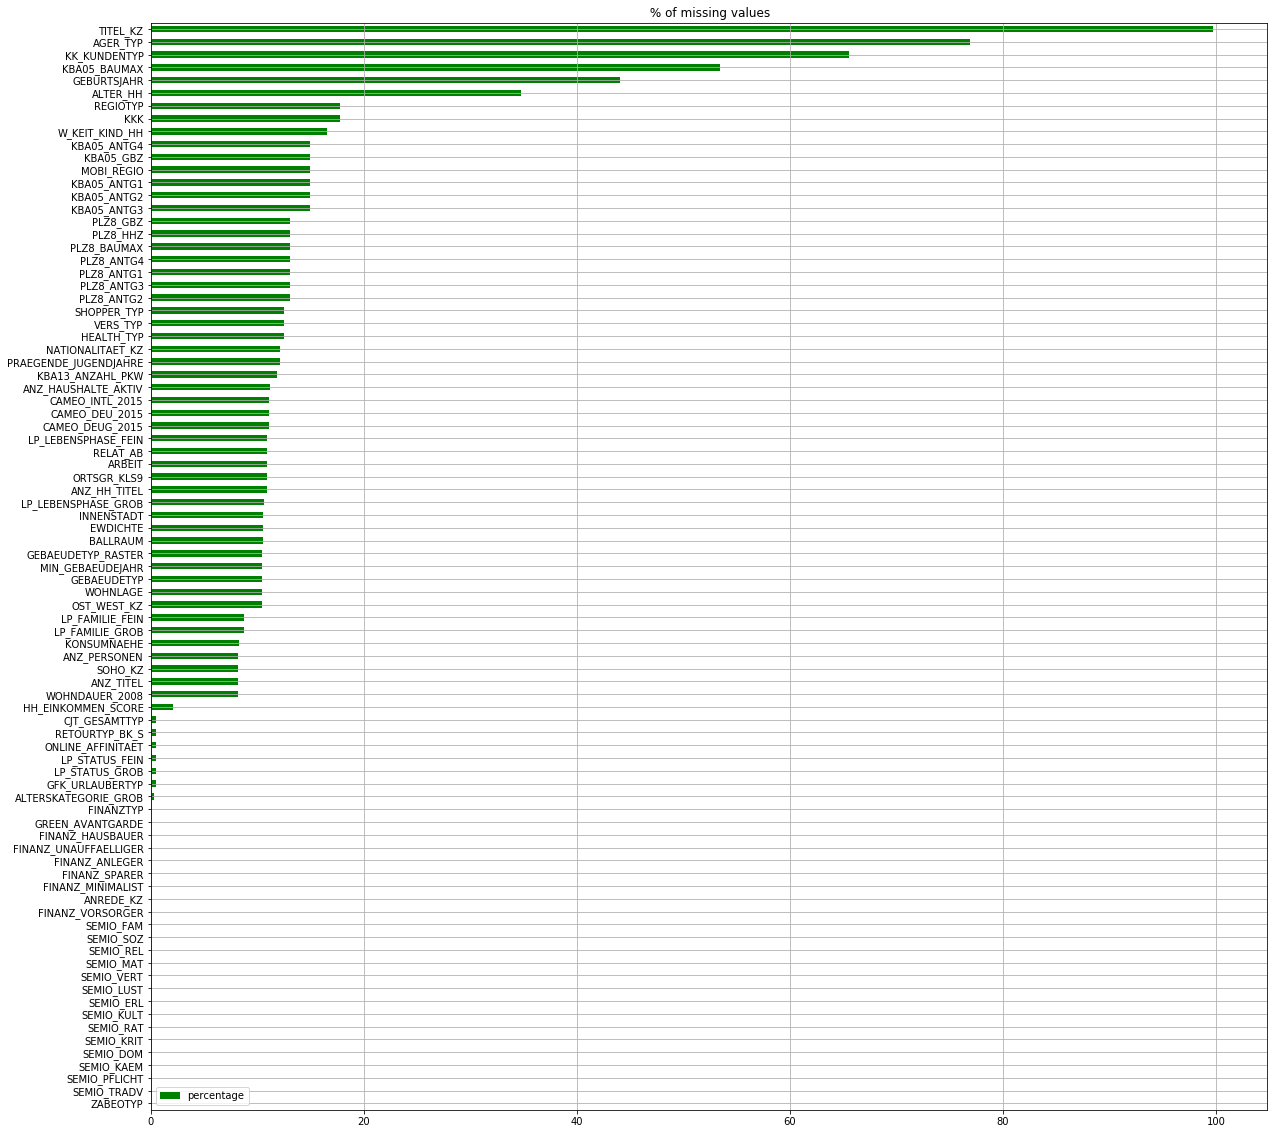

In [171]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

print(azdias.isnull().sum())

           
null_table_percen = (azdias.isnull().sum())/(azdias.shape[0])*100
print(null_table_percen.head(n=15))


table_miss=pd.DataFrame({'percentage':null_table_percen.values}, index=null_table_percen.index.values).sort_values('percentage')
table_miss.columns=["percentage"]
table_miss.plot.barh(figsize=(20,20),color="green",grid="on",
                    title=" % of missing values")


In [172]:
# Investigate patterns in the amount of missing data in each column.

#general statistics of missing data
print(table_miss.describe())

#columns without missings
print(table_miss[table_miss["percentage"]==0])



       percentage
count   85.000000
mean    11.054139
std     16.449815
min      0.000000
25%      0.000000
50%     10.451729
75%     13.073637
max     99.757636
                       percentage
ZABEOTYP                      0.0
SEMIO_TRADV                   0.0
SEMIO_PFLICHT                 0.0
SEMIO_KAEM                    0.0
SEMIO_DOM                     0.0
SEMIO_KRIT                    0.0
SEMIO_RAT                     0.0
SEMIO_KULT                    0.0
SEMIO_ERL                     0.0
SEMIO_LUST                    0.0
SEMIO_VERT                    0.0
SEMIO_MAT                     0.0
SEMIO_REL                     0.0
SEMIO_SOZ                     0.0
SEMIO_FAM                     0.0
FINANZ_VORSORGER              0.0
ANREDE_KZ                     0.0
FINANZ_MINIMALIST             0.0
FINANZ_SPARER                 0.0
FINANZ_ANLEGER                0.0
FINANZ_UNAUFFAELLIGER         0.0
FINANZ_HAUSBAUER              0.0
GREEN_AVANTGARDE              0.0
FINANZTYP             

In [173]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

outliers_missing=table_miss[table_miss["percentage"]>30.0]#select columns
name_outliers=outliers_missing.index.values               # to obtain an array 
print(name_outliers)
azdias_clean=azdias.drop(name_outliers,1)                 #removing

#comparing
print(azdias.shape)
print(azdias_clean.shape)


['ALTER_HH' 'GEBURTSJAHR' 'KBA05_BAUMAX' 'KK_KUNDENTYP' 'AGER_TYP'
 'TITEL_KZ']
(891221, 85)
(891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

##### Which columns were removed from the dataset?
* Given the above barplot , I removed esencially the columns that have 30% or more of missing values,that is,['ALTER_HH' 'GEBURTSJAHR' 'KBA05_BAUMAX' 'KK_KUNDENTYP' 'AGER_TYP'
 'TITEL_KZ']




#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   
3       2.0                   4.0          2            2.0   
4       NaN                   3.0          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                     

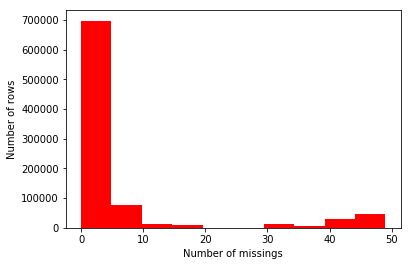

In [174]:
# How much data is missing in each row of the dataset?

missing_per_row=azdias_clean.isnull().sum(axis=1)

#general check 
print(azdias.head())
print(azdias.shape)
#check inside
print(missing_per_row.describe())
print(missing_per_row.head())
print(missing_per_row.tail())


#Distribution of missings

plt.hist(missing_per_row,color="red")
plt.ylabel('Number of rows')
plt.xlabel('Number of missings');

In [175]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
print(type(missing_per_row))
missing_a=missing_per_row[missing_per_row>20]
missing_b=missing_per_row[missing_per_row<20]

index_missing_a=missing_a.index.tolist()
index_missing_b=missing_b.index.tolist()
type(index_missing_b)


azdias_part_a=azdias_clean.loc[index_missing_a]
azdias_part_b=azdias_clean.loc[index_missing_b]

print(azdias_part_a.shape)
print(azdias_part_b.shape)

<class 'pandas.core.series.Series'>
(93795, 79)
(797077, 79)


In [176]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
missing_per_col_a= azdias_part_a.isnull().sum(axis=0)
missing_per_col_b= azdias_part_b.isnull().sum(axis=0)

print(missing_per_col_a.head())

# list of columns to compare
print(missing_per_col_a[missing_per_col_a==0].index.values.tolist())
print(missing_per_col_b[missing_per_col_b==0].index.values.tolist())


#function to compare barcharts

def comparing_plts(column):
    fig = plt.figure(figsize=(14,4))
    #a
    ax1 = fig.add_subplot(1,2,1)
    ax1.title.set_text('Variable in part A(>20 missings)')
    sns.countplot(azdias_part_a[column])
    #b
    ax2 = fig.add_subplot(1,2,2)
    ax2.title.set_text('Variable in part B(<20 missings)')
    sns.countplot(azdias_part_b[column]);
    #final
    fig.suptitle(column)
    plt.show()

ALTERSKATEGORIE_GROB     97
ANREDE_KZ                 0
CJT_GESAMTTYP           220
FINANZ_MINIMALIST         0
FINANZ_SPARER             0
dtype: int64
['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP']
['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'ZABEOTYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'WOHNDAUER_2008', 'GEBAEUDETYP', 'MIN_G

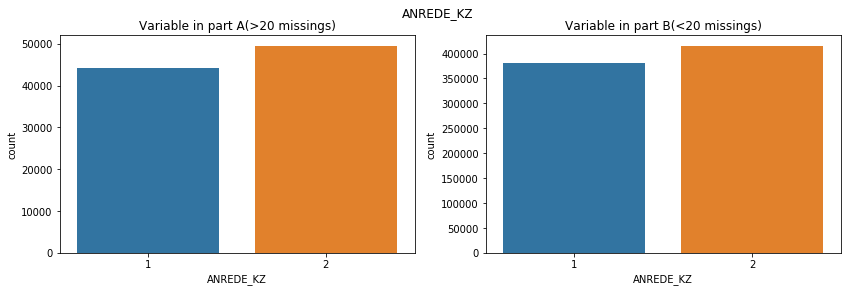

In [177]:
comparing_plts("ANREDE_KZ")

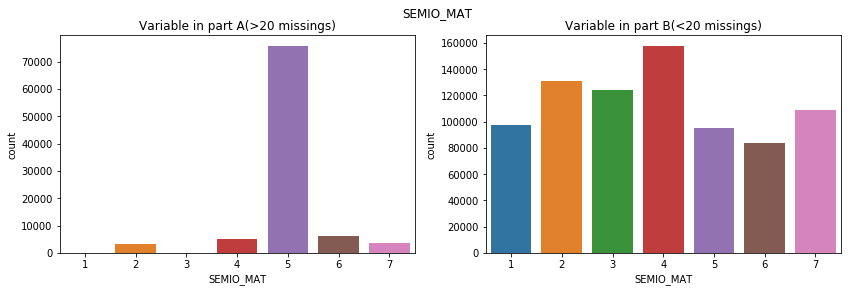

In [178]:
comparing_plts("SEMIO_MAT")

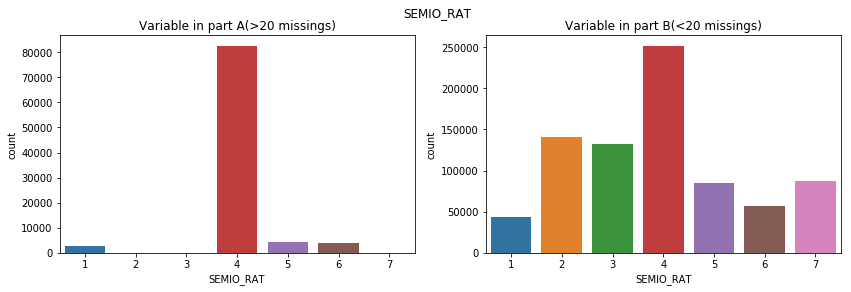

In [179]:
comparing_plts("SEMIO_RAT")

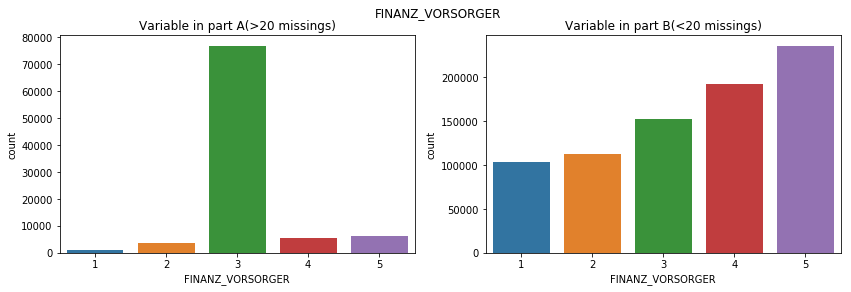

In [180]:
comparing_plts("FINANZ_VORSORGER")

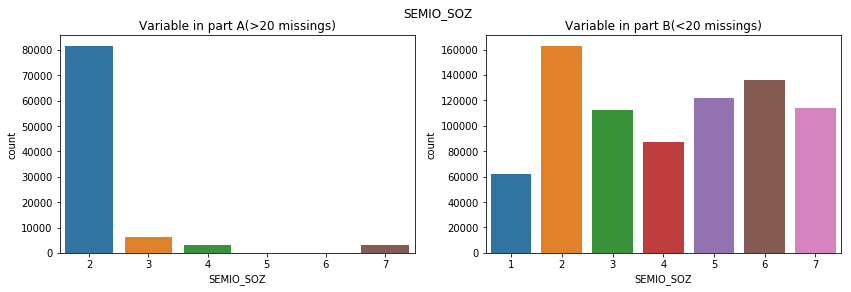

In [181]:
comparing_plts("SEMIO_SOZ")

#### Discussion 1.1.3: Assess Missing Data in Each Row

* Some columns display similar values, such as "ANREDE_KZ". But the other varialbes show distinct patterns.

* Finally, I decided continue with analysis using only  "azdias_part_b" , that is , the dataset with lower missings because this subset has more variability


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [182]:
# How many features are there of each data type?
feat_info.type.head(n=6)
feat_info["type"].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [183]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

#General analysiss
categorical_variables=feat_info[feat_info["type"]=="categorical"].attribute.tolist() # categorical variables list
print(azdias[categorical_variables].dtypes.tail(n=4)) # there are tree variables objects 

print(azdias["OST_WEST_KZ"].value_counts().head(n=4))
print(azdias["CAMEO_DEUG_2015"].value_counts().head(n=4))
print(azdias["CAMEO_DEU_2015"].value_counts().head(n=4))

GEBAEUDETYP        float64
OST_WEST_KZ         object
CAMEO_DEUG_2015     object
CAMEO_DEU_2015      object
dtype: object
W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64
8    134441
9    108177
6    105874
4    103912
Name: CAMEO_DEUG_2015, dtype: int64
6B    56672
8A    52438
4C    47819
2D    35074
Name: CAMEO_DEU_2015, dtype: int64


In [184]:
#ONLY CATEGORICAL VARIABLES

#general
col_2_level     = []
col_multi_level = []

for column in categorical_variables:
    if azdias[column].nunique() == 2:
        col_2_level.append(column)
    else:
        col_multi_level.append(column)
    
    
#binary        
for element in col_2_level:
    print(azdias[element].value_counts())        
    
print(col_2_level)

2    465305
1    425916
Name: ANREDE_KZ, dtype: int64
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    810834
1.0      6888
Name: SOHO_KZ, dtype: int64
2.0    398722
1.0    381303
Name: VERS_TYP, dtype: int64
W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']


In [185]:
#multilevel        
for element in col_multi_level:
    print(azdias[element].value_counts())        


2.0    98472
1.0    79802
3.0    27104
Name: AGER_TYP, dtype: int64
4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
1.0     98869
Name: CJT_GESAMTTYP, dtype: int64
6    290367
1    199572
4    130625
2    110867
5    106436
3     53354
Name: FINANZTYP, dtype: int64
12.0    138545
5.0     120126
10.0    109127
8.0      88042
11.0     79740
4.0      63770
9.0      60614
3.0      56007
1.0      53600
2.0      46702
7.0      42956
6.0      27138
Name: GFK_URLAUBERTYP, dtype: int64
1.0     426379
10.0    137913
2.0     104305
11.0     51719
8.0      23032
7.0      20730
4.0      12303
5.0      11920
9.0      11148
6.0       9022
3.0       4958
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    426379
5.0    200780
2.0    104305
4.0     52784
3.0     29181
Name: LP_FAMILIE_GROB, dtype: int64
1.0     219275
9.0     143238
2.0     118236
10.0    118022
4.0      78317
5.0      74493
3.0      74105
6.0      30914
8.0      19708
7.0      10059
Name: LP_STATUS_FEIN, dtype: int64
1.0 

In [186]:
# Re-encode categorical variable(s) to be kept in the analysis.


#Re-encode : binary

azdias_part_b["OST_WEST_KZ"].replace(dict(W=1, O=0),inplace=True) # i only recoded this variable
azdias_part_b["OST_WEST_KZ"].value_counts()

#multilevel (note : we need to considere the fact that we already drop some variables)

print(col_multi_level)
pre_deleted=['AGER_TYP' ,'TITEL_KZ' ,'KK_KUNDENTYP']
col_multi_level_last = []
for i in col_multi_level:
    if i not in pre_deleted:
        col_multi_level_last.append(i)
        
        
print(len(col_multi_level_last))
print(len(col_multi_level))



['AGER_TYP', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
13
16


In [187]:
#finally
print(col_multi_level_last)
azdias_part_b.drop(col_multi_level_last, axis=1, inplace=True)    #other multilevel were deleted
azdias_part_b.shape

#(797077, 66)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


(797077, 66)

#### Discussion 1.2.1: Re-Encode Categorical Features

 Which ones did you keep, which did you drop, and what engineering steps did you perform?)
* I decided to retain binary variables, previously doing a recoding
* I decided delete multilevel columns in order to avoid a great dimension of the final dataset



#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [188]:
mixed_variables=feat_info[feat_info["type"]=="mixed"].attribute.tolist()
print(mixed_variables)

# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias_part_b["PRAEGENDE_JUGENDJAHRE"].head(n=4)
azdias_part_b["PRAEGENDE_JUGENDJAHRE"].value_counts()


#first variable decade

azdias_part_b['decade'] =azdias_part_b['PRAEGENDE_JUGENDJAHRE'].map({1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6})
print(azdias_part_b['decade'].value_counts())


#Second variable movement

azdias_part_b['movement']=azdias_part_b['PRAEGENDE_JUGENDJAHRE'].map({1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1})
print(azdias_part_b['movement'].value_counts())


['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']
6.0    225333
4.0    175064
5.0    151670
3.0    114307
2.0     74261
1.0     28118
Name: decade, dtype: int64
0.0    593618
1.0    175135
Name: movement, dtype: int64


In [189]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
print(azdias_part_b['CAMEO_INTL_2015'].value_counts())

#first variable
azdias_part_b['wealth']=azdias_part_b['CAMEO_INTL_2015'].str[0].astype("float")
print(azdias_part_b['wealth'].value_counts())

#second variable
azdias_part_b['life_stage']=azdias_part_b['CAMEO_INTL_2015'].str[1].astype("float")
print(azdias_part_b['life_stage'].value_counts())


51    133665
41     92297
24     91070
14     62833
43     56642
54     45366
25     39593
22     33128
23     26635
13     26305
45     26122
55     23928
52     20537
31     18952
34     18511
15     16965
44     14815
12     13226
35     10349
32     10345
33      9926
Name: CAMEO_INTL_2015, dtype: int64
5.0    223496
2.0    190426
4.0    189876
1.0    119329
3.0     68083
Name: wealth, dtype: int64
1.0    244914
4.0    232595
3.0    119508
5.0    116957
2.0     77236
Name: life_stage, dtype: int64


#### Discussion 1.2.2: Engineer Mixed-Type Features

####  Which ones did you keep, which did you drop, and what engineering steps did you perform?

* I decided to maintatin both variables  with the  objective don't loss more information about the dataset 
* About PRAEGENDE_JUGENDJAHRE,  I assigned each level of this variable to a new scheme of levels proposed by the dictionary.
* About CAMEO_INTL_2015,  first of all I change the type of variable to string in order to easily strip characters, then only follow the steps  proposed.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [190]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
print(azdias_part_b.shape)
print(azdias_part_b.dtypes) #there are object variables


# Now I have multilevel variables so I need to tranform them to dummies using one hot enconding

####
#New multilevel variables
###

#first cast variables to category
azdias_part_b['decade'].astype('category')
azdias_part_b['movement'].astype('category')
azdias_part_b['wealth'].astype('category')
azdias_part_b['life_stage'].astype('category')

#second
azdias_last=pd.get_dummies(azdias_part_b, columns=["decade","movement","wealth","life_stage"])
#considering ALL CATEGORY VARIABLES GENERATED !!!
print(azdias_last.shape)


####
#drop variables 
#####

#azdias_last.drop("CAMEO_INTL_2015") 
#azdias_last.drop("PRAEGENDE_JUGENDJAHRE") 
print(azdias_last.shape)





(797077, 70)
ALTERSKATEGORIE_GROB     float64
ANREDE_KZ                  int64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
GREEN_AVANTGARDE           int64
HEALTH_TYP               float64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
PRAEGENDE_JUGENDJAHRE    float64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
SEMIO_ERL                  int64
SEMIO_KULT                 int64
SEMIO_RAT                  int64
SEMIO_KRIT                 int64
SEMIO_DOM                  int64
SEMIO_KAEM                 int64
SEMIO_PFLICHT              int64
SEMIO_TRADV                int64
SOHO_KZ                  float64
VERS_TYP                 float

In [191]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#
#drop variables 
#
mix_variables=feat_info[feat_info['type']=='mixed'].attribute.tolist()
mix_variables.remove("KBA05_BAUMAX")# KBA05_BAUMAX was deleted in other section  , remove delete the element in the original object
print(mix_variables)

#print(azdias_last.drop(mix_variables, axis = 1).shape)
azdias_last2=azdias_last.drop(mix_variables, axis = 1)
print(azdias_last2.shape)

#azdias_last.drop(mix_variables)
#print(azdias_last_2.shape)
#print(azdias_last.drop("CAMEO_INTL_2015").dtypes[azdias_last.dtypes=="object"])

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']
(797077, 78)


In [192]:
#before
print(azdias_last.dtypes[azdias_last.dtypes=="object"])
#now
print(azdias_last2.dtypes[azdias_last2.dtypes=="object"])
#azdias_last2["PRAEGENDE_JUGENDJAHRE"]
#azdias_last2["CAMEO_INTL_2015"]

CAMEO_INTL_2015    object
dtype: object
Series([], dtype: object)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [193]:
def clean_data(db,feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    
    #df=db.copy()

    for n_col in feat_info.index:
        feat_info.loc[n_col,'missing_or_unknown'] = str(feat_info.loc[n_col,'missing_or_unknown']).strip('[]').split(',')
        for idx in range(0,len(feat_info.loc[n_col,'missing_or_unknown'])):
            try:
                feat_info.loc[n_col,'missing_or_unknown'][idx] = int(feat_info.loc[index,'missing_or_unknown'][idx])
            except:
                continue
        db.loc[:,(feat_info.loc[n_col, 'attribute'])].replace(feat_info.loc[n_col,'missing_or_unknown'], np.nan, inplace=True)
   # remove selected columns and rows, ...

    #columns
    
    
    null_table_percen = (db.isnull().sum())/(db.shape[0])*100
    table_miss=pd.DataFrame({'percentage':null_table_percen.values}, index=null_table_percen.index.values).sort_values('percentage')
    table_miss.columns=["percentage"]

    outliers_missing=table_miss[table_miss["percentage"]>30.0]#select columns
    name_outliers=outliers_missing.index.values               # to obtain an array 
    raw_db_clean=db.drop(name_outliers,1)  
    
    #row
    missing_per_row=raw_db_clean.isnull().sum(axis=1)

    missing_a=missing_per_row[missing_per_row>20]
    missing_b=missing_per_row[missing_per_row<20]

    index_missing_a=missing_a.index.tolist()
    index_missing_b=missing_b.index.tolist()
        
    db_part_a=raw_db_clean.loc[index_missing_a]
    db_part_b=raw_db_clean.loc[index_missing_b]

    #re encode
    #bivariate
    db_part_b["OST_WEST_KZ"].replace(dict(W=1, O=0),inplace=True) # i only recoded this variable
    #multilevel

    col_multi_level_last=['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    db_part_b.drop(col_multi_level_last, axis=1, inplace=True)    #other multilevel were deleted

    
    # select, re-encode, and engineer column values.
    
    db_part_b['decade'] =db_part_b['PRAEGENDE_JUGENDJAHRE'].map({1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6})
    db_part_b['movement']=db_part_b['PRAEGENDE_JUGENDJAHRE'].map({1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1})
    
    
    
    #######################
    db_part_b['wealth']=db_part_b['CAMEO_INTL_2015'].str[0].astype("float")
    db_part_b['life_stage']=db_part_b['CAMEO_INTL_2015'].str[1].astype("float")

    
    
    db_part_b['decade'].astype('category')
    db_part_b['movement'].astype('category')
    db_part_b['wealth'].astype('category')
    db_part_b['life_stage'].astype('category')
    db_last=pd.get_dummies(db_part_b, columns=["decade","movement","wealth","life_stage"])
    
    
    
    
    mix_variables=feat_info[feat_info['type']=='mixed'].attribute.tolist()
    mix_variables.remove("KBA05_BAUMAX")# KBA05_BAUMAX was deleted in other section  , remove delete the element in the original object
    db_last2=db_last.drop(mix_variables, axis = 1)
    
    # Return the cleaned dataframe.
    
    return db_last2
    
    
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [194]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer

imp= Imputer(strategy='median')
azdias_last_imp= imp.fit_transform(azdias_last2)

#finally
azdias_last_imp_df = pd.DataFrame(azdias_last_imp, columns = azdias_last2.columns)


In [195]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
azdias_std=scaler.fit_transform(azdias_last_imp_df)

#finally
azdias_std_df = pd.DataFrame(azdias_std, columns = azdias_last_imp_df.columns)

### Discussion 2.1: Apply Feature Scaling
 * I replaced all missing values with the median value in that column.This in order to avoid the risk of bias 
 * Finally, the variables were standarized using standardscaler , wich remove the mean and scale to unit variance

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [196]:
# Apply PCA to the data.

# Apply PCA to the data.
from sklearn.decomposition import PCA

pca= PCA()
azdi_pca=pca.fit(azdias_std_df)


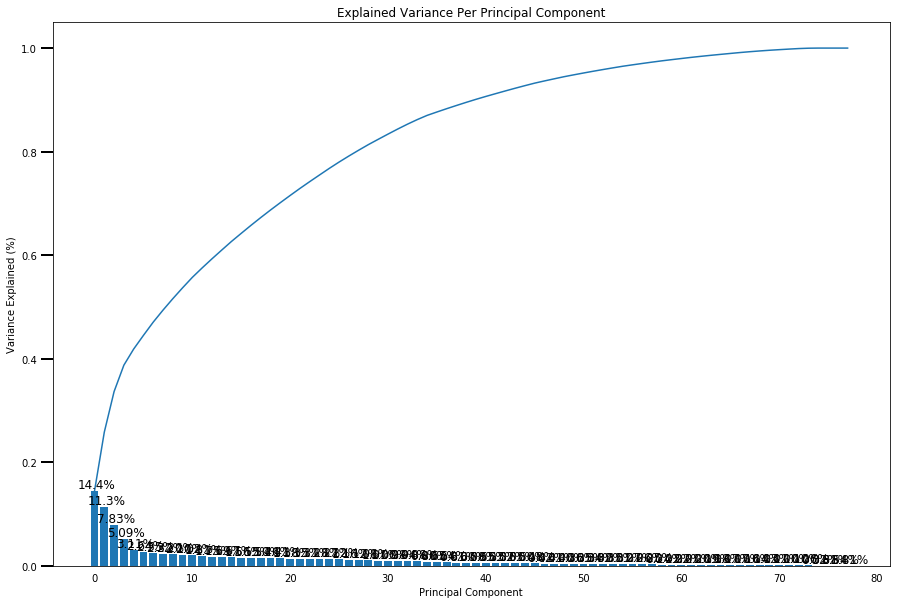

In [197]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(azdi_pca)
# Reference :
# udacity intro to machine learning course



In [198]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_last= PCA(n_components=40)
azdi_pca_select=pca_last.fit_transform(azdias_std_df)


### Discussion 2.2: Perform Dimensionality Reduction

* I decided to retain only 40 components because with them I already have more than 80% of the variance of the original dataset

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [199]:
pd_df = pd.DataFrame(pca_last.components_, columns=azdias_std_df.columns.tolist()) #object pca and pca.fit
#print(pd_df)
#print(azdias_std_df)
print(pd_df.iloc[0].sort_values(ascending=False))

PLZ8_ANTG3               0.221140
PLZ8_ANTG4               0.214548
HH_EINKOMMEN_SCORE       0.203726
ORTSGR_KLS9              0.190390
EWDICHTE                 0.188869
wealth_5.0               0.172418
life_stage_1.0           0.162674
FINANZ_HAUSBAUER         0.162369
KBA05_ANTG4              0.152912
PLZ8_ANTG2               0.150416
ARBEIT                   0.141238
KBA05_ANTG3              0.136093
FINANZ_SPARER            0.135319
ANZ_HAUSHALTE_AKTIV      0.134716
RELAT_AB                 0.132201
SEMIO_PFLICHT            0.103991
SEMIO_REL                0.101055
movement_0.0             0.098881
SEMIO_RAT                0.085323
decade_6.0               0.083162
SEMIO_TRADV              0.078189
SEMIO_MAT                0.070907
REGIOTYP                 0.070243
SEMIO_FAM                0.070157
SEMIO_KULT               0.064097
FINANZ_UNAUFFAELLIGER    0.063771
FINANZ_ANLEGER           0.062607
KKK                      0.042076
wealth_4.0               0.041453
SEMIO_KAEM    

In [200]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.


def map_weights(n_component, columns, pca):
    pd_df = pd.DataFrame(pca.components_, columns=columns) #dataframe with all components
    return pd_df.iloc[n_component].sort_values(ascending=False)    # to select only one component

first_pca = map_weights(0, azdias_std_df.columns.tolist(), pca_last)
print(first_pca)


PLZ8_ANTG3               0.221140
PLZ8_ANTG4               0.214548
HH_EINKOMMEN_SCORE       0.203726
ORTSGR_KLS9              0.190390
EWDICHTE                 0.188869
wealth_5.0               0.172418
life_stage_1.0           0.162674
FINANZ_HAUSBAUER         0.162369
KBA05_ANTG4              0.152912
PLZ8_ANTG2               0.150416
ARBEIT                   0.141238
KBA05_ANTG3              0.136093
FINANZ_SPARER            0.135319
ANZ_HAUSHALTE_AKTIV      0.134716
RELAT_AB                 0.132201
SEMIO_PFLICHT            0.103991
SEMIO_REL                0.101055
movement_0.0             0.098881
SEMIO_RAT                0.085323
decade_6.0               0.083162
SEMIO_TRADV              0.078189
SEMIO_MAT                0.070907
REGIOTYP                 0.070243
SEMIO_FAM                0.070157
SEMIO_KULT               0.064097
FINANZ_UNAUFFAELLIGER    0.063771
FINANZ_ANLEGER           0.062607
KKK                      0.042076
wealth_4.0               0.041453
SEMIO_KAEM    

In [201]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

seconda_pca = map_weights(1, azdias_std_df.columns.tolist(), pca_last)
print(seconda_pca)

ALTERSKATEGORIE_GROB     0.261342
FINANZ_VORSORGER         0.236955
SEMIO_ERL                0.224705
SEMIO_LUST               0.183785
RETOURTYP_BK_S           0.165942
decade_3.0               0.125677
W_KEIT_KIND_HH           0.118103
decade_2.0               0.111338
FINANZ_HAUSBAUER         0.107506
SEMIO_KRIT               0.106849
SEMIO_KAEM               0.100984
EWDICHTE                 0.082970
PLZ8_ANTG3               0.082337
ORTSGR_KLS9              0.081376
ANREDE_KZ                0.079071
PLZ8_ANTG4               0.078465
FINANZ_MINIMALIST        0.078142
decade_1.0               0.070425
KBA05_ANTG4              0.064892
decade_4.0               0.063555
WOHNDAUER_2008           0.062839
ARBEIT                   0.062065
SEMIO_DOM                0.061994
RELAT_AB                 0.059164
ANZ_HAUSHALTE_AKTIV      0.057193
PLZ8_ANTG2               0.056982
wealth_5.0               0.056966
HH_EINKOMMEN_SCORE       0.048167
life_stage_5.0           0.042795
KBA05_ANTG3   

In [202]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
third_pca = map_weights(2, azdias_std_df.columns.tolist(), pca_last)
print(type(third_pca))
print(third_pca)


<class 'pandas.core.series.Series'>
SEMIO_VERT               0.345075
SEMIO_SOZ                0.264898
SEMIO_FAM                0.255585
SEMIO_KULT               0.241787
FINANZ_MINIMALIST        0.153873
RETOURTYP_BK_S           0.102742
FINANZ_VORSORGER         0.091721
W_KEIT_KIND_HH           0.085173
SEMIO_REL                0.079907
ALTERSKATEGORIE_GROB     0.067740
SEMIO_MAT                0.063181
movement_1.0             0.060088
GREEN_AVANTGARDE         0.060088
SEMIO_LUST               0.057881
decade_3.0               0.055717
decade_2.0               0.050393
ORTSGR_KLS9              0.048547
EWDICHTE                 0.048008
PLZ8_ANTG4               0.043938
PLZ8_ANTG3               0.043858
ARBEIT                   0.034420
RELAT_AB                 0.031684
WOHNDAUER_2008           0.030782
PLZ8_ANTG2               0.029919
decade_1.0               0.025871
life_stage_1.0           0.025826
KBA05_ANTG4              0.025214
wealth_5.0               0.024138
ANZ_HAUSHALT

### Discussion 2.3: Interpret Principal Components

 Can we interpret positive and negative values from them in a meaningful way?)

* **First Component** : the first component captures the variance as follows : 

   * positively:
     PLZ8_ANTG3, PLZ8_ANTG4(Number of 10+ family houses in the PLZ8 region), HH_EINKOMMEN_SCORE(Estimated household net income)
   * negatively
     KBA05_ANTG1, PLZ8_ANTG1, MOBI_REGIO 
   * **conclusion**: this feature seems to represent the population density and income status.
     
* **Second Component** : The second components capture the variance  as follows :

   * positively:
     ALTERSKATEGORIE_GROB(Estimated age), FINANZ_VORSORGER(Financial typology), SEMIO_ERL
   * negatively
     SEMIO_TRADV,FINANZ_SPARER,SEMIO_REL(Personality typology)         
   * **conclusion**: this feature seems to represent age, financial  and personality .
   
* **Third Component** : The third components capture the variance  as follows :

   * positively:
     SEMIO_VERT(Dreamful),SEMIO_SOZ(ocially-minded) ,SEMIO_FAM (family-minded)
   * negatively
     SEMIO_DOM,SEMIO_KAEM,ANREDE_KZ(Gender)  
   * **conclusion**: this feature  seems to represent the relation between personality type and Gender.
     

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [61]:
from sklearn.cluster import KMeans
def clustering_and_score(dataset, k):
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(dataset)
    score = np.abs(kmeans.score(dataset))

    return score



# Over a number of different cluster counts...

n_clusters = list(np.arange(2,31,4)) #HERE

kmeans_scores=[]
for i in n_clusters:
    # run k-means clustering on the data and...
    kmeans_scores.append(clustering_and_score(azdi_pca_select, i))
    # compute the average within-cluster distances.
    #print('The average distance of {} for {} clusters'.format(i,clustering_and_score(azdi_pca_select, i))
    

In [60]:
n_clusters = list(np.arange(2,31,4))
print(n_clusters)


[2, 6, 10, 14, 18, 22, 26, 30]


[2, 6, 10, 14, 18, 22, 26, 30]
[49213435.894785978, 40785844.380721301, 37287829.5279366, 35441052.015581377, 33862542.668292962, 33041269.962965645, 31805057.770231001, 31164145.033582766]


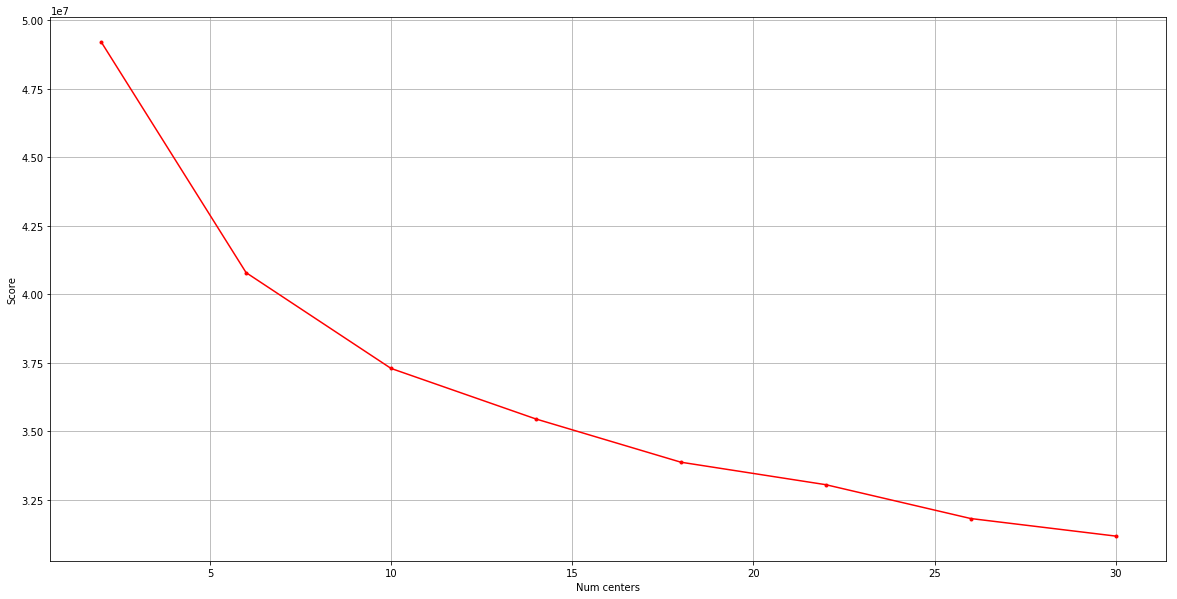

In [68]:
print(n_clusters)
print(kmeans_scores)
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(20,10)) 
plt.plot(n_clusters, kmeans_scores, linestyle='-', marker='.', color='red');
plt.xlabel('Num centers');
plt.ylabel('Score');
plt.grid()



In [203]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_last= KMeans(n_clusters=21) # to obtain 20 
kmeans_last.fit(azdi_pca_select)
azdias_predictions=kmeans_last.predict(azdi_pca_select)

### Discussion 3.1: Apply Clustering to General Population
 
 #### how many clusters have you decided to segment the population?
 * Using the elbow criteria, I should retain only 15 groups, but in order not to lose much information I finally decided to use    20 groups

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [204]:
# Load in the customer demographics data.
customer = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv",sep=";") #to avoid errors

#customer.shape 
#customer["CAMEO_INTL_2015"].value_counts()
print(feat_info.loc[59,:])

attribute             CAMEO_INTL_2015
information_level       microcell_rr4
type                            mixed
missing_or_unknown            [-1,XX]
Name: 59, dtype: object


In [205]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.


#applying all steps

customer_final=clean_data(customer, feat_info)
customer_final.shape

#rest of steps

#imputation
imp = Imputer(strategy="median")
imp.fit(customer_final)             
customer_imput    = imp.transform(customer_final)
customer_imput_df = pd.DataFrame(customer_imput, columns=customer_final.columns)

#scale
scaler=StandardScaler()
azdias_std=scaler.fit_transform(customer_imput_df)
customer_scaled= scaler.transform(customer_imput_df)
customer_scaled_df= pd.DataFrame(customer_scaled, columns=customer_final.columns)

#Extract principal components

pca_last= PCA(n_components=40)
customer_pca_select=pca_last.fit_transform(customer_scaled_df)

#customers_pca=pca_last.transform(customer_scale_df)


#kmeans
from sklearn.cluster import KMeans

kmeans_last= KMeans(n_clusters=21) # to obtain 20 .
kmeans_last.fit(customer_pca_select)
customer_predict= kmeans_last.predict(customer_pca_select)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

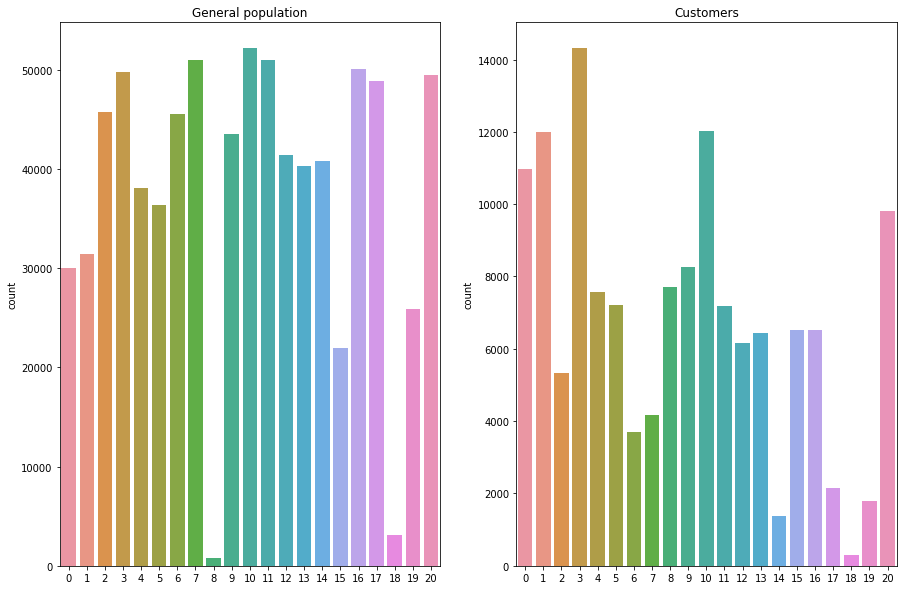

In [206]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax[0].set_title("General population")
sns.countplot(azdias_predictions, ax=ax[0])
ax[1].set_title("Customers")
sns.countplot(customer_predict, ax=ax[1])

In [214]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_14 = scaler.inverse_transform(pca_last.inverse_transform(kmeans_last.cluster_centers_[14]))
underrepresented = pd.Series(data = centroid_14, index = customer_final.columns)
underrepresented.sort_values(ascending=False)

MIN_GEBAEUDEJAHR        1993.085450
GEBURTSJAHR             1308.849608
KBA13_ANZAHL_PKW         678.466132
ALTER_HH                  11.501033
WOHNDAUER_2008             8.679631
SEMIO_LUST                 5.518754
SEMIO_VERT                 5.162416
ORTSGR_KLS9                5.082918
SEMIO_ERL                  4.877349
INNENSTADT                 4.790157
FINANZ_VORSORGER           4.600261
BALLRAUM                   4.375596
SEMIO_SOZ                  4.357101
FINANZ_MINIMALIST          4.274628
W_KEIT_KIND_HH             4.156201
ANZ_HAUSHALTE_AKTIV        4.046316
SEMIO_KRIT                 3.995669
REGIOTYP                   3.963955
RETOURTYP_BK_S             3.932362
SEMIO_DOM                  3.924699
SEMIO_KULT                 3.900708
SEMIO_FAM                  3.885086
EWDICHTE                   3.871301
GEBAEUDETYP_RASTER         3.834956
PLZ8_HHZ                   3.671764
MOBI_REGIO                 3.658977
KBA05_GBZ                  3.657506
PLZ8_GBZ                   3

In [213]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

centroid_0 = scaler.inverse_transform(pca_last.inverse_transform(kmeans_last.cluster_centers_[0]))
overrepresented = pd.Series(data = centroid_0, index = customer_final.columns)
overrepresented.sort_values(ascending=False)

MIN_GEBAEUDEJAHR        1992.660259
GEBURTSJAHR             1411.484928
KBA13_ANZAHL_PKW         691.150968
ALTER_HH                  10.361815
WOHNDAUER_2008             8.881831
SEMIO_ERL                  6.755349
SEMIO_LUST                 6.104755
SEMIO_KRIT                 5.767056
SEMIO_KAEM                 5.753154
SEMIO_DOM                  5.660039
ORTSGR_KLS9                5.462633
FINANZ_VORSORGER           4.963828
INNENSTADT                 4.678883
W_KEIT_KIND_HH             4.659736
FINANZ_MINIMALIST          4.446038
MOBI_REGIO                 4.284994
KBA05_GBZ                  4.155800
EWDICHTE                   4.081055
BALLRAUM                   4.046102
GEBAEUDETYP_RASTER         4.029587
PLZ8_GBZ                   3.881293
ALTERSKATEGORIE_GROB       3.709207
PLZ8_HHZ                   3.677607
RETOURTYP_BK_S             3.665195
SEMIO_SOZ                  3.377666
SEMIO_VERT                 3.319581
KONSUMNAEHE                3.296919
REGIOTYP                   3

### Discussion 3.3: Compare Customer Data to Demographics Data

##### Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?

* **cluster 14(under represented)** was related to the features as follows:

   * **very positively** :
   
        MIN_GEBAEUDEJAHR 
        GEBURTSJAHR              (Year of birth)
        KBA13_ANZAHL_PKW         (Number of cars in the PLZ8 region)         
             
   * **little positively** :
   
        decade_6.0                 
        TITEL_KZ             (Academic title flag )                   
        ANZ_TITEL            (Number of professional academic title holders in household)                                   
        
        
        
* **cluster 0(over represented)** was related to the features as follows:

   * **positively** :
   
        MIN_GEBAEUDEJAHR      
        GEBURTSJAHR      
        KBA13_ANZAHL_PKW              (Number of cars in the PLZ8 region)  
        
   * **negatively** :
   
        decade_5.0               (Number of professional academic title holders in building  )      
        KBA05_ANTG4                
        decade_6.0                 (home office)
         
         
The over-represented individuals are mostly people with professional degrees, mostly adults, in contrast, the youngest people and with a sparser lifestyle are those who are under-represented.




 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.